# Projeto final - Predição de reincidência criminal
O projeto desenvolvido tem como objetivo a predição de reincidência criminal, baseado em
dados de presidiários passados. Após uma longa busca por um *dataset* que contivesse
informação de reincidência, encontrei a base de dados do [National Corrections Reporting
Program](https://www.icpsr.umich.edu/icpsrweb/NACJD/studies/36404/summary#), que
identifica de forma anônima os condenados. Desta forma, uma duplicidade de ids representa
um reincidente.

## Análise e processamento dos dados

Antes de processar o dataset com Python, substitui os espaços em branco por NaN utilizando
a ferramenta `sed`:
`sed -e 's/ /NaN/g'`

In [2]:
import pandas as pd
import numpy as np

In [3]:
def render_table(table, title):
  print(pd.Series(table).to_frame(title))

O campo **ABT_INMATE_ID** é especificado como uma *string* de 19 caracteres. Apesar do
formato livre, observa-se que os dados na verdade estão no formato **A[0-9]{18}**. Desta
forma, ignorando o primeiro caractere, um inteiro de 64 *bits* é suficiente para armazenar
este dado.

In [4]:
def parse_id(id):
  return np.int64(id[1:])

As colunas que possuem dados faltantes são associadas com tipos capitalizados. Já as
colunas completas, são associadas com tipos em minúsculo.

In [5]:
index = 'ABT_INMATE_ID'

columns = {
  'SEX': 'uint8',
  'ADMTYPE': 'Int8',
  'OFFGENERAL': 'Int8',
  'EDUCATION': 'Int8',
  'ADMITYR': 'Int16',
  'RELEASEYR': 'Int16',
  'MAND_PRISREL_YEAR': 'Int16',
  'PROJ_PRISREL_YEAR': 'Int16',
  'PARELIG_YEAR': 'Int16',
  'SENTLGTH': 'Int8',
  'OFFDETAIL': 'Int8',
  'RACE': 'Int8',
  'AGEADMIT': 'Int8',
  'AGERELEASE': 'Int8',
  'TIMESRVD': 'Int8',
  'RELTYPE': 'Int8',
  'STATE' : 'uint8'
}

O dataset acompanha um *codebook* descrevendo os possíveis valores de cada coluna,
incluindo os valores especiais para dados faltantes. Apesar disso, como descrito
anteriormente, algumas células possuiam dados faltantes na forma de espaços. Estes valores
foram corrigidos previamente.

In [6]:
missing_values = {
  'ADMTYPE': '9',             # 9 = missing.
  'OFFGENERAL': [ '5', '9' ], # 5 = other/unspecified; 9 = missing.
  'EDUCATION': '99',          # 99 = ungraded/unknown.
  'ADMITYR': '9999',          # 9999 = missing.
  'RELEASEYR': '9999',        # 9999 = missing.
  'SENTLGTH': '9',            # 9 = missing.
  'OFFDETAIL': '99',          # 14 = other/unspecified; 99 = missing.
  'RACE': '9',                # 9 = missing.
  'AGEADMIT': '9',            # 9 = missing.
  'AGERELEASE': '9',          # 9 = missing.
  'TIMESRVD': '9',            # 9 = missing.
  'RELTYPE': '9'              # 9 = missing.
}

Por motivos computacionais, subconjuntos do conjunto de dados total foram utilizados.

In [7]:
nrows = 2_000_000

In [8]:
data = pd.read_csv(
  'data/nan/full.tsv',
  sep = '\t',
  nrows = nrows,
  usecols = [ index ] + list(columns),
  dtype = columns,
  na_values = missing_values,
  converters = { index: parse_id }
)

In [9]:
data.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 18 columns):
ABT_INMATE_ID        int64
SEX                  uint8
ADMTYPE              Int8
OFFGENERAL           Int8
EDUCATION            Int8
ADMITYR              Int16
RELEASEYR            Int16
MAND_PRISREL_YEAR    Int16
PROJ_PRISREL_YEAR    Int16
PARELIG_YEAR         Int16
SENTLGTH             Int8
OFFDETAIL            Int8
RACE                 Int8
AGEADMIT             Int8
AGERELEASE           Int8
TIMESRVD             Int8
RELTYPE              Int8
STATE                uint8
dtypes: Int16(5), Int8(10), int64(1), uint8(2)
memory usage: 85.8 MB


### Dados faltantes
Vamos analisar os dados faltantes.

In [10]:
missing_data = data.isnull().mean()

In [11]:
ax = missing_data.plot(
  kind = 'bar',
  title = 'Dados Faltantes',
  zorder = 2 # bars over grid
)

ax.set(
  xlabel = 'Coluna',
  ylabel = '% de dados faltantes'
)

ax.yaxis.grid();

As seguintes colunas apresentam muitos dados faltantes, e portanto serão desconsideradas:
- MAND\_PRISREL\_YEAR: ano de soltura mandatório.
- PROJ\_PRISREL\_YEAR: ano de soltura projetado.
- PARELIG\_YEAR: ano de eligibilidade à condicional.

In [12]:
data, data_full = data.drop(
  [
    'MAND_PRISREL_YEAR',
    'PROJ_PRISREL_YEAR',
    'PARELIG_YEAR'
  ],
  axis = 1
), data;

Ainda, as instâncias com dados faltantes nas demais colunas serão removidas.

In [13]:
data = data.dropna();

In [14]:
render_table(
  {
    'totais': data_full.shape[0],
    'completas': data.shape[0]
  },
  'instâncias'
);

           instâncias
totais        2000000
completas     1565130


### Target
Nosso target é predizer se um condenado apresentou reincidência. Como esta informação
está implícita no dataset, precisamos calculá-la. Consideraremos que há reincidência para
uma instância se há uma outra instância com a mesma identificação, em um ano superior de
admissão. Para tal, é necessário definir uma margem de reincidência, pois os dados não
podem discernir se haverá ou não reincidência no futuro. Considerando as limitações do
dataset, definimos uma margem de 4 anos, o que já limita os dados consideravelmente,
considerando que os últimos 4 anos de dados constituem 21.9% do total.

In [15]:
target = 'RECIDIVIST'

In [16]:
data_sorted = data.sort_values(by = ['ADMITYR'])

data = data_sorted.assign(
  **{
    target: data_sorted.duplicated(
      subset = index,
      keep = 'last'
    )
  }
)

Margem de reincidência:

In [17]:
recidivism_margin = 4

In [18]:
release_year_counts = data['RELEASEYR'] \
  .value_counts(normalize = True) \
  .sort_index(ascending = False)

In [19]:
print(
  'Porcentagem dos dados dispostos nos últimos {} anos: {:.1%}.'.format(
    recidivism_margin,
    release_year_counts.head(recidivism_margin).sum()
  )
)

Porcentagem dos dados dispostos nos últimos 4 anos: 13.9%.


Abaixo, observamos que o *target* não aprenda problema de desbalanceamento.

In [20]:
data[target].value_counts(normalize = True)

False    0.530868
True     0.469132
Name: RECIDIVIST, dtype: float64

In [41]:
data, data_complete = data[
  data['ADMITYR'] <= (release_year_counts.index.max() - recidivism_margin)
], data;

In [42]:
render_table(
  {
    'completas': data_complete.shape[0],
    'até 2010': data.shape[0]
  },
  'instâncias'
);

           instâncias
completas     1565130
até 2010      1434340


### Features 
A feature **RACE** foi desconsiderada a princípio para o aprendizado por motivos éticos,
de forma a não reproduzir preconceitos intrínsecos da nossa sociedade.

In [43]:
features = [
  'SEX',
  'ADMTYPE',
  'OFFGENERAL',
  'EDUCATION',
  'SENTLGTH',
  'OFFDETAIL',
  'AGEADMIT',
  'AGERELEASE',
  'TIMESRVD',
  'RELTYPE',
  # 'RACE'
]

disconsidered_features = [
  index,
  'ADMITYR',
  'RELEASEYR',
  'STATE',
  'RACE'
]

In [44]:
data = data.drop(disconsidered_features, axis = 1);

#### Estudo de caso: Etnia
Além de desconsiderar a *feature* **RACE**, podemos analisar qual seria seu impacto nos
modelos. Para isso, descomentei a *feature* acima e rodei os modelos. Os resultados estão
dispostos no poster. A servir de comparação, analisamos a distribuição das raças nas
sentenças finais.

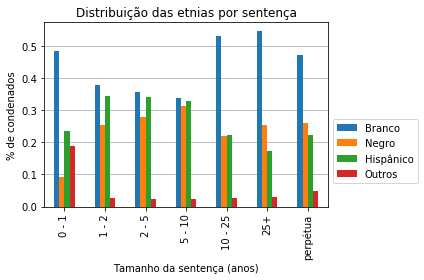

In [45]:
# data_complete.groupby(['RACE', 'SENTLGTH']).size()
frequency = pd.crosstab(
  data_complete['SENTLGTH'],
  data_complete['RACE'],
  normalize = 'index'
).rename(
  index = {
    0: '0 - 1',
    1: '1 - 2',
    2: '2 - 5',
    3: '5 - 10',
    4: '10 - 25',
    5: '25+',
    6: 'perpétua'
  },
  columns = {
    1: 'Branco',
    2: 'Negro',
    3: 'Hispânico',
    4: 'Outros'
  }
)

ax = frequency.plot.bar(zorder = 2)

ax.legend(bbox_to_anchor=(1.0, 0.5))

ax.yaxis.grid();

ax.set(
  title = 'Distribuição das etnias por sentença',
  xlabel = 'Tamanho da sentença (anos)',
  ylabel = '% de condenados'
);

fig = ax.get_figure()
fig.tight_layout()
fig.savefig('images/race.png')

### Encoding
Todas as *features*, exceto as relativas a anos, são categóricas. Portanto, precisamos
codificá-las.

In [46]:
data = pd.get_dummies(
  data,
  columns = features,
  drop_first = True
);

In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1434340 entries, 1199349 to 275491
Data columns (total 39 columns):
RECIDIVIST      1434340 non-null bool
SEX_2           1434340 non-null uint8
ADMTYPE_2       1434340 non-null uint8
ADMTYPE_3       1434340 non-null uint8
OFFGENERAL_2    1434340 non-null uint8
OFFGENERAL_3    1434340 non-null uint8
OFFGENERAL_4    1434340 non-null uint8
SENTLGTH_1      1434340 non-null uint8
SENTLGTH_2      1434340 non-null uint8
SENTLGTH_3      1434340 non-null uint8
SENTLGTH_4      1434340 non-null uint8
SENTLGTH_5      1434340 non-null uint8
SENTLGTH_6      1434340 non-null uint8
OFFDETAIL_2     1434340 non-null uint8
OFFDETAIL_3     1434340 non-null uint8
OFFDETAIL_4     1434340 non-null uint8
OFFDETAIL_5     1434340 non-null uint8
OFFDETAIL_6     1434340 non-null uint8
OFFDETAIL_7     1434340 non-null uint8
OFFDETAIL_8     1434340 non-null uint8
OFFDETAIL_9     1434340 non-null uint8
OFFDETAIL_10    1434340 non-null uint8
OFFDETAIL_11    1434340 n

## Aprendizado

In [48]:
import gc

from types import SimpleNamespace as Object

In [49]:
features = set(data)
features.remove(target)

### Validação
Como validação, utilizei a técnica de validação cruzada *k-fold* com *k = 5*.

In [50]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

N_FOLDS = 5

kfold = KFold(n_splits = N_FOLDS)

phases = {
  'Train': lambda score: score.train, # get train score
  'Test': lambda score: score.test   # get test score
}

def cross_validate(alg):
  scores = {
    metric: Object(
      function = function,
      train = [],
      test = []
    )
    for metric, function in {
      'accuracy': accuracy_score,
      'precision': precision_score,
      'recall': recall_score,
      'f1': f1_score,
    }.items()
  }

  for train, test in kfold.split(data):
    train = data.iloc[train]
    test  = data.iloc[test]

    model = alg.fit(train[features], train[target])

    prediction = Object(
      train = model.predict(train[features]),
      test  = model.predict(test[features])
    )

    for score in scores.values():
      score.train.append(
        score.function(train[target], prediction.train)
      )
      score.test.append(
        score.function(test[target], prediction.test)
      )

  for score in scores.values():
    score.train = np.mean(score.train)
    score.test  = np.mean(score.test)

  return scores

### Naive Bayes

In [51]:
from sklearn.naive_bayes import GaussianNB

gnb = cross_validate(GaussianNB())

gnb

{'accuracy': namespace(function=<function accuracy_score at 0x7fcea2554bf8>, test=0.5598505235857607, train=0.5601698342094622),
 'precision': namespace(function=<function precision_score at 0x7fcea2561378>, test=0.5355438122518542, train=0.5373325241877266),
 'recall': namespace(function=<function recall_score at 0x7fcea2561400>, test=0.8840302789075363, train=0.8869260019395815),
 'f1': namespace(function=<function f1_score at 0x7fcea25610d0>, test=0.6638387240120855, train=0.6690410108131901)}

### Random Forest

In [52]:
from sklearn.ensemble import RandomForestClassifier

rfc = cross_validate(
  RandomForestClassifier(
    n_estimators = 10,
    n_jobs = 4,
    verbose = 1
  )
)

gc.collect();

rfc

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    9.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    1.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    9.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    1.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]

{'accuracy': namespace(function=<function accuracy_score at 0x7fcea2554bf8>, test=0.6155841711170295, train=0.6356120236485073),
 'precision': namespace(function=<function precision_score at 0x7fcea2561378>, test=0.6129958848827161, train=0.624983445288546),
 'recall': namespace(function=<function recall_score at 0x7fcea2561400>, test=0.6686904811860066, train=0.6809675840275642),
 'f1': namespace(function=<function f1_score at 0x7fcea25610d0>, test=0.6313067779376609, train=0.6515079652419475)}

### LightGBM

In [54]:
import lightgbm as lgb

data_lgb = lgb.Dataset(
  data[features],
  label = data[target]
)

data_lgb.raw_data = None

gc.collect();

In [55]:
from sklearn.metrics import f1_score

def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat), True

lgb.cv(
  {
    'num_leaves': 31,
    'objective': 'binary',
    'num_threads': 3,
  },
  data_lgb,
  10,
  nfold = 5,
  feval = lgb_f1_score
)

{'binary_logloss-mean': [0.6855205066448014,
  0.6793359914404525,
  0.6742808101233239,
  0.6701503714256506,
  0.6667388898776478,
  0.6639318679450268,
  0.6615956497554633,
  0.6596481014239114,
  0.6579986103551373,
  0.6566042893668727],
 'binary_logloss-stdv': [3.2822229676342674e-05,
  6.507112466374084e-05,
  0.00010616586736357847,
  0.0001337398002987556,
  0.00016094787814410104,
  0.0001886438088009964,
  0.00022271209415618805,
  0.0002335556232301343,
  0.00023966855567881385,
  0.0002746101441004666],
 'f1-mean': [0.654155382577984,
  0.6498909159464541,
  0.6489365649900078,
  0.6366007530607396,
  0.6305102788899752,
  0.6310677457039907,
  0.628318820305667,
  0.6322566491329453,
  0.6332979818957283,
  0.6332488006087925],
 'f1-stdv': [0.0007594201111875938,
  0.000801569817587546,
  0.0005213562792695519,
  0.014481221436713836,
  0.012789282340365185,
  0.012111335744730384,
  0.00528295951370343,
  0.0006226424752795636,
  0.0012779338721296725,
  0.0010083119651

In [56]:
gc.collect();

### XGBoost

In [57]:
from xgboost import XGBClassifier

xgb = cross_validate(
  XGBClassifier(
    n_jobs = 4
  )
)

xgb

{'accuracy': namespace(function=<function accuracy_score at 0x7fcea2554bf8>, test=0.6188504817546747, train=0.628839047924481),
 'precision': namespace(function=<function precision_score at 0x7fcea2561378>, test=0.6175736573455964, train=0.6228272350813385),
 'recall': namespace(function=<function recall_score at 0x7fcea2561400>, test=0.6516234321196744, train=0.656834498994229),
 'f1': namespace(function=<function f1_score at 0x7fcea25610d0>, test=0.6275176395805389, train=0.6392267989549723)}

## Conclusão
A disciplina de aprendizado de máquina apresenta técnicas muito poderosas para modelar
sistemas complexos e de difícil explicação. Um dos tópicos que mais chamou minha atenção
foi a questão da explicabilidade. Neste trabalho, pude observar na prática como os modelos
podem trazer não apenas boas soluções para os problemas em si, mas também *insights* novos
sobre como olhar para problemas já conhecidos.